# **Задача: классификация сообщений на спам / не спам**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir data
!cp /content/drive/MyDrive/for_ds/* /content/data/

## Импорты, первичный осмотр, препроцессинг, токенизация

In [5]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import lightgbm
from xgboost import XGBClassifier

import joblib

In [6]:
train = pd.read_csv('data/train_spam.csv')
test = pd.read_csv('data/test_spam.csv')

In [7]:
train.head(n=3)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...


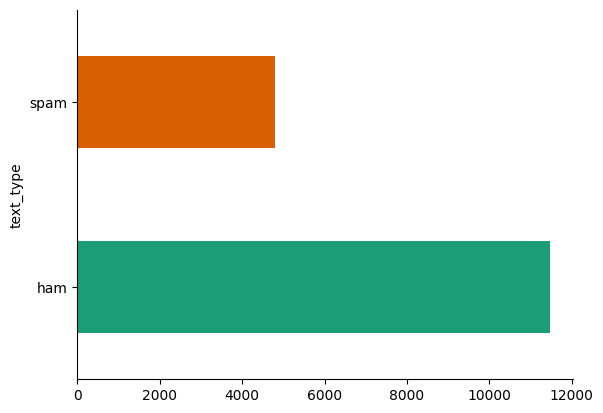

In [8]:
train.groupby('text_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
train.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


In [10]:
test.describe()

,text
count,4070
unique,4070
top,energy conference mark we are really swamped a...
freq,1


In [11]:
def preprocess(df):
    dataframe = df.copy()
    dataframe['dl'] = dataframe.text.apply(len)
    if 'text_type' in dataframe.columns:
        dataframe['text_type'] = dataframe.text_type.apply(
            lambda x: 0 if x == 'ham' else 1
        )
    return dataframe

In [12]:
train_p = preprocess(train)

In [13]:
test_p = preprocess(test)


In [14]:
train_ratio = 0.9

In [15]:
train_p

,text_type,text,dl
0,0,make sure alex knows his birthday is over in f...,86
1,0,a resume for john lavorato thanks vince i will...,520
2,1,plzz visit my website moviesgodml to get all m...,126
3,1,urgent your mobile number has been awarded wit...,139
4,0,overview of hr associates analyst project per ...,733
...,...,...,...
16273,1,if you are interested in binary options tradin...,114
16274,1,dirty pictureblyk on aircel thanks you for bei...,454
16275,0,or you could do this g on mon 1635465 sep 1635...,799
16276,0,insta reels par 80 गंद bhara pada hai 👀 kuch b...,102


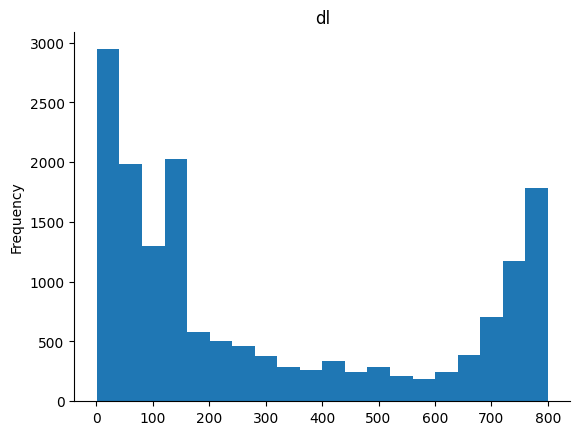

In [16]:
train_p['dl'].plot(kind='hist', bins=20, title='dl')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
train_ps, val_ps = train_test_split(train_p, train_size=train_ratio, random_state=42)


In [22]:
X_train, y_train = train_ps.drop(['text_type'], axis=1), train_ps['text_type']
X_val, y_val = val_ps.drop(['text_type'], axis=1), val_ps['text_type']

In [23]:
X_train

,text,dl
15717,tiger team mr bayne attached is the updated do...,97
1047,could you not read me my love i answered you,44
7800,thanx 4 e brownie its v nice,28
15760,on thu sep 1635465 1635465 at 1635465 1635465 ...,786
9345,i thought since we met a week be4 and i scold ...,82
...,...,...
13418,transition to research group an update molly j...,739
5390,avistar users and allocated charges avistar ha...,568
860,account for sale 💕total mythics 23💕 🥳account l...,474
15795,a a program question gwyn just because the a a...,748


In [24]:
column_trans_tfidf = ColumnTransformer(
    [('words',
      TfidfVectorizer(stop_words="english",max_df=0.7), 'text'),
     ],
    remainder='passthrough')

column_trans_count = ColumnTransformer(
    [('words',
      CountVectorizer(min_df=1000,
      analyzer='word', ngram_range=(1, 2)), 'text'),
     ],
    remainder='passthrough')

In [25]:
X_train_ct = column_trans_count.fit_transform(X_train)
X_val_ct = column_trans_count.transform(X_val)

X_train_t = column_trans_tfidf.fit_transform(X_train)
X_val_t = column_trans_tfidf.transform(X_val)
joblib.dump(column_trans_tfidf, 'ct1.pkl')

['ct1.pkl']

In [26]:
RAND = 42 # setting random state for classifiers training

## XGBOOST

Начнем с CountVectorizer, он может быть обучен на ПК:

In [27]:
%%time

model1 = XGBClassifier(
                    device='cuda',
                    max_depth=0,
                    learning_rate=0.1,
                    colsample_bytree=0.95,
                    eval_metric='auc',
                    scale_pos_weight=3,
                    random_state=RAND,
                    n_estimators=28,
                    early_stopping_rounds=2)

model1.fit(X_train_ct,
            y_train,
            eval_set=[(X_train_ct, y_train),
                        (X_val_ct, y_val)])

[0]	validation_0-auc:0.97017	validation_1-auc:0.91219
[1]	validation_0-auc:0.97757	validation_1-auc:0.92342
[2]	validation_0-auc:0.98671	validation_1-auc:0.93357
[3]	validation_0-auc:0.98767	validation_1-auc:0.93733
[4]	validation_0-auc:0.98819	validation_1-auc:0.94097
[5]	validation_0-auc:0.98870	validation_1-auc:0.94336
[6]	validation_0-auc:0.98932	validation_1-auc:0.94493
[7]	validation_0-auc:0.98961	validation_1-auc:0.94510
[8]	validation_0-auc:0.98980	validation_1-auc:0.94511
[9]	validation_0-auc:0.99018	validation_1-auc:0.94630
[10]	validation_0-auc:0.99051	validation_1-auc:0.94681
[11]	validation_0-auc:0.99092	validation_1-auc:0.94749
[12]	validation_0-auc:0.99130	validation_1-auc:0.94897
[13]	validation_0-auc:0.99167	validation_1-auc:0.94934
[14]	validation_0-auc:0.99213	validation_1-auc:0.94987
[15]	validation_0-auc:0.99238	validation_1-auc:0.95026
[16]	validation_0-auc:0.99276	validation_1-auc:0.95013
[17]	validation_0-auc:0.99306	validation_1-auc:0.95083
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=28, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

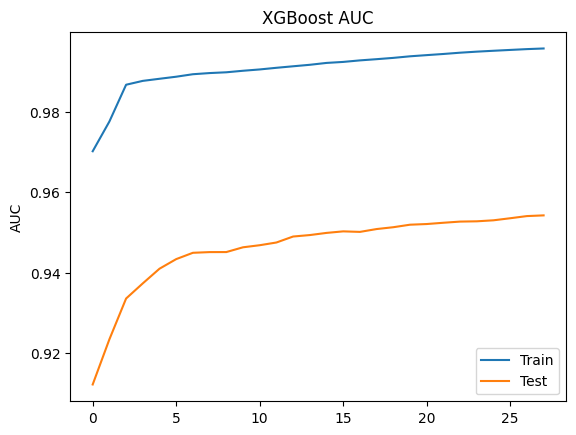

In [28]:
results = model1.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [31]:
auc = roc_auc_score(y_val, model1.predict_proba(X_val_ct)[:, 1])
print(classification_report(y_val, model1.predict(X_val_ct)))
print(f'ROC AUC: {auc}')

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1173
           1       0.77      0.88      0.82       455

    accuracy                           0.89      1628
   macro avg       0.86      0.89      0.87      1628
weighted avg       0.90      0.89      0.89      1628

ROC AUC: 0.9542311908040809


Добавим TF-IDF, памяти ПК не хватило, так что это обучение проводилось в Google Colab A100

In [32]:
%%time

model1 = XGBClassifier(
                    device='cuda',
                    max_depth=0,
                    learning_rate=0.1,
                    colsample_bytree=0.95,
                    eval_metric='auc',
                    scale_pos_weight=3,
                    random_state=RAND,
                    n_estimators=28,
                    early_stopping_rounds=2)

model1.fit(X_train_t,
            y_train,
            eval_set=[(X_train_t, y_train),
                        (X_val_t, y_val)])

[0]	validation_0-auc:0.98815	validation_1-auc:0.94331
[1]	validation_0-auc:0.99619	validation_1-auc:0.96789
[2]	validation_0-auc:0.99692	validation_1-auc:0.96717
CPU times: user 7.07 s, sys: 86.6 ms, total: 7.15 s
Wall time: 4.21 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=28, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

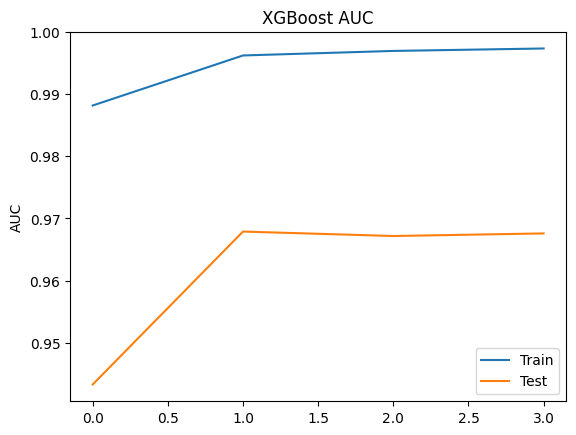

In [33]:
results = model1.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [36]:
auc = roc_auc_score(y_val, model1.predict_proba(X_val_t)[:, 1])
print(classification_report(y_val, model1.predict(X_val_t)))
print(f'ROC AUC: {auc}')

              precision    recall  f1-score   support

           0       0.98      0.80      0.89      1173
           1       0.66      0.97      0.78       455

    accuracy                           0.85      1628
   macro avg       0.82      0.89      0.83      1628
weighted avg       0.89      0.85      0.86      1628

ROC AUC: 0.9678911029294661


In [37]:
filename = 'xgbm2.pkl'
joblib.dump(model1, filename)

['xgbm2.pkl']

Результат: 0.967

## LightGBM

In [39]:
y_train_l = y_train.astype('float32')
y_val_l = y_val.astype('float32')
X_train_l = X_train_t.astype('float64')
X_val_l = X_val_t.astype('float64')
X_train_ctl = X_train_ct.astype('float64')
X_val_ctl = X_val_ct.astype('float64')

In [40]:
model = lightgbm.LGBMClassifier(num_leaves=2**9,
                                max_depth=-1,
                                learning_rate=0.125,
                                n_estimators=100,
                                metric='auc',
                                is_unbalance=True,
                                random_state=RAND)

model.fit(X_train_ctl,
          y_train_l,
          eval_set=[(X_train_ctl, y_train_l),
                    (X_val_ctl, y_val_l)],
          eval_metric='auc')

[LightGBM] [Info] Number of positive: 4354, number of negative: 10296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 14650, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297201 -> initscore=-0.860661
[LightGBM] [Info] Start training from score -0.860661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMClassifier(is_unbalance=True, learning_rate=0.125, metric='auc',
               num_leaves=512, random_state=42)

In [41]:
joblib.dump(model, 'lgb7.pkl')

['lgb7.pkl']

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

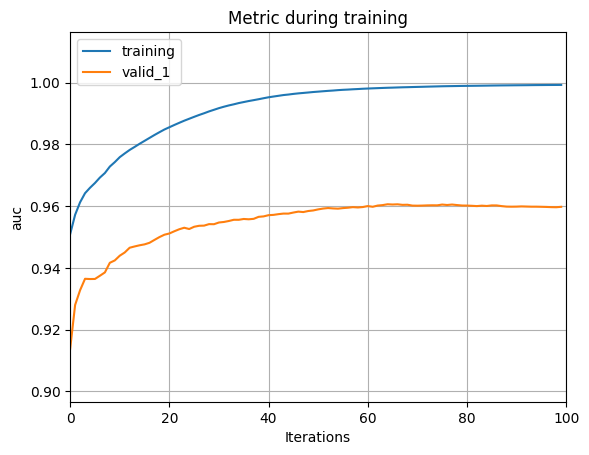

In [42]:
fig, ax = plt.subplots()
lightgbm.plot_metric(model, metric='auc', ax=ax)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

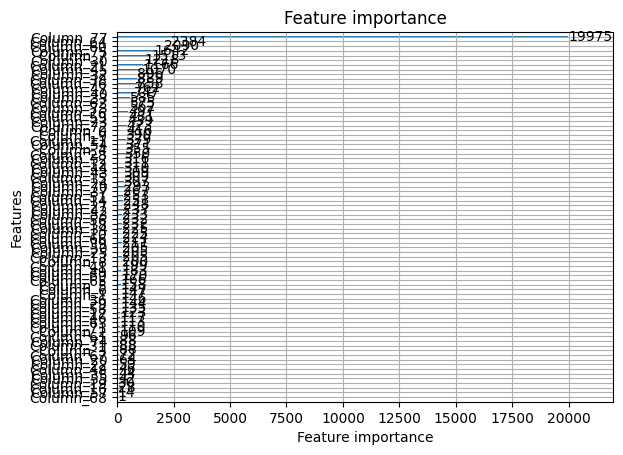

In [43]:
lightgbm.plot_importance(model)

Text(0.5, 0, 'Relative Importance')

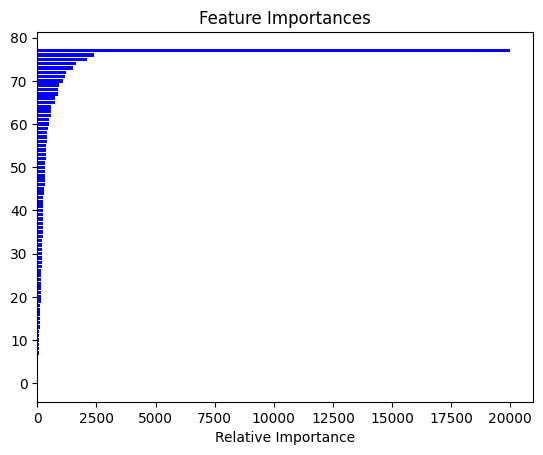

In [44]:
features=model.feature_name_
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Relative Importance')

In [46]:
auc = roc_auc_score(y_val, model.predict_proba(X_val_ctl)[:, 1])
print(classification_report(y_val, model.predict(X_val_ctl)))
print(f'ROC AUC: {auc}')

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1173
           1       0.81      0.87      0.84       455

    accuracy                           0.91      1628
   macro avg       0.88      0.90      0.89      1628
weighted avg       0.91      0.91      0.91      1628

ROC AUC: 0.9597744114368156


Результат: 0.96

In [119]:
model = lightgbm.LGBMClassifier(num_leaves=2**9,
                                max_depth=-1,
                                learning_rate=0.125,
                                n_estimators=120,
                                metric='auc',
                                is_unbalance=True,
                                random_state=RAND)

model.fit(X_train_l,
          y_train_l,
          eval_set=[(X_train_l, y_train_l),
                    (X_val_l, y_val_l)],
          eval_metric='auc')

[LightGBM] [Info] Number of positive: 4354, number of negative: 10296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88072
[LightGBM] [Info] Number of data points in the train set: 14650, number of used features: 3084
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297201 -> initscore=-0.860661
[LightGBM] [Info] Start training from score -0.860661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(is_unbalance=True, learning_rate=0.125, metric='auc',
               n_estimators=120, num_leaves=512, random_state=42)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

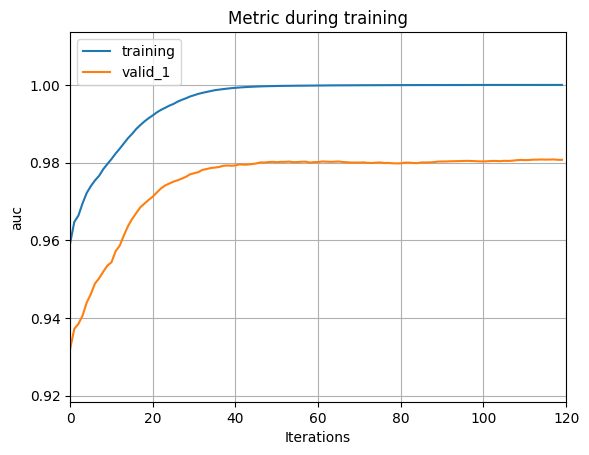

In [120]:
fig, ax = plt.subplots()
lightgbm.plot_metric(model, metric='auc', ax=ax)

In [121]:
auc = roc_auc_score(y_val, model.predict_proba(X_val_l)[:, 1])
print(classification_report(y_val, model.predict(X_val_l)))
print(f'ROC AUC: {auc}')

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1173
           1       0.90      0.91      0.91       455

    accuracy                           0.95      1628
   macro avg       0.93      0.94      0.93      1628
weighted avg       0.95      0.95      0.95      1628

ROC AUC: 0.9807041211133284


In [123]:
joblib.dump(model, 'lgb9.pkl')

['lgb9.pkl']

Попробуем BERT

## BERT

In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install transformers[torch]

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import torch
import random
from datasets import load_dataset
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

seed_all(RAND)

def tokenize_function(examples):
    return tokenizer(examples["text"],
                     padding='max_length',
                     truncation=True,
                     max_length=512)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [ ]:
tokenizer= AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
t = pd.read_csv('data/train_spam.csv')
t['labels'] = t.text_type.map({'ham':0, 'spam':1})
t.drop(t.columns.difference(['text','labels']), axis=1, inplace=True)
train_t, val_t = train_test_split(t, train_size=train_ratio, random_state=42)
train_t.to_csv('data/train_t.csv', index=False)
val_t.to_csv('data/val_t.csv', index=False)
dataset = load_dataset("csv", data_files={'train': "data/train_t.csv", 'test': "data/val_t.csv"})

BATCH_SIZE = 32
NUM_PROCS = 32
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    batch_size=BATCH_SIZE,
    num_proc=NUM_PROCS
)

training_args = TrainingArguments(
    prediction_loss_only=True,
    output_dir = './training',
    num_train_epochs = 1,
    weight_decay = 0.01,
    learning_rate = 1e-5,
    logging_dir = './logs',
    load_best_model_at_end = True,
    evaluation_strategy ='steps',
    logging_strategy = 'steps',
    save_strategy = 'steps',
    save_steps = 3000,
    eval_steps = 500,
    logging_steps = 500,
    save_total_limit = 10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    seed=RAND)

eval_dataset = tokenized_datasets['test'].shuffle(seed=RAND).select(range(1000))


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/14650 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/1628 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets['train']

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 14650
})

In [ ]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = tokenized_datasets['train'],
                  eval_dataset = eval_dataset,
                  compute_metrics = compute_metrics)
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.602800,0.288200
1000,0.299800,0.352620
1500,0.327600,0.295352
2000,0.378000,0.256493
2500,0.371600,0.284333
3000,0.279000,0.221572
3500,0.204800,0.265368
4000,0.259600,0.283504
4500,0.274800,0.214426
5000,0.268400,0.198666


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=14650, training_loss=0.24864510103297316, metrics={'train_runtime': 1109.0044, 'train_samples_per_second': 13.21, 'train_steps_per_second': 13.21, 'total_flos': 1940647390310400.0, 'train_loss': 0.24864510103297316, 'epoch': 1.0})

In [ ]:
trainer.save_model("berttune")

In [ ]:
!zip berttune.zip ./berttune/*

  adding: berttune/config.json (deflated 46%)
  adding: berttune/model.safetensors (deflated 8%)
  adding: berttune/special_tokens_map.json (deflated 42%)
  adding: berttune/tokenizer_config.json (deflated 75%)
  adding: berttune/tokenizer.json (deflated 71%)
  adding: berttune/training_args.bin (deflated 51%)
  adding: berttune/vocab.txt (deflated 53%)


In [ ]:
!cp  /content/berttune.zip /content/drive/MyDrive/for_ds/

In [ ]:
def db_predict(text, model):
  inputs = tokenizer(text, return_tensors="pt").to(device)
  with torch.no_grad():
    logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()
  return predicted_class_id

In [ ]:
predictions = [db_predict(item, model) for item in val_t['text']]
ground_truth = val_t['labels']

roc_auc = roc_auc_score(ground_truth, predictions)

print(f"ROC AUC Score: {roc_auc}")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


ROC AUC Score: 0.9575419465445041


**Выбираем LightGBM по метрике на val (ROC AUC 0.98)**

## Test

In [124]:
X_test = column_trans_tfidf.transform(test_p)


In [125]:
preds_test = model.predict(X_test.astype('float64'))

In [126]:
np.histogram(preds_test)

(array([2854,    0,    0,    0,    0,    0,    0,    0,    0, 1216]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [127]:
test['text_type'] = preds_test.astype(bool)

In [128]:
test

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,False
1,original message from bitbitch magnesium net p...,False
2,java for managers vince durasoft who just taug...,False
3,there is a youtuber name saiman says,False
4,underpriced issue with high return on equity t...,True
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,False
4066,baylor enron case study cindy yes i shall co a...,False
4067,boring as compared to tp,False
4068,hellogorgeous hows u my fone was on charge lst...,False


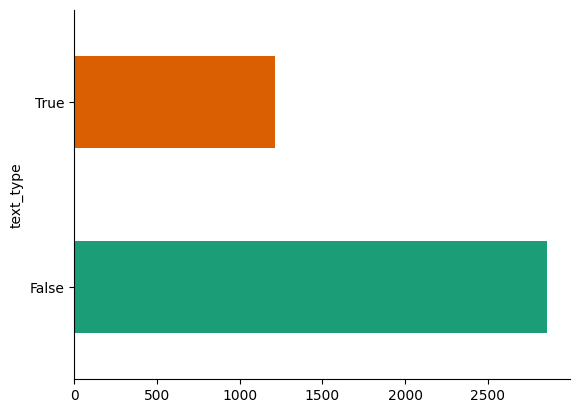

In [129]:
test.groupby('text_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [131]:
test.to_csv('test1.csv')